In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy import stats
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim
from torch.jit import script, trace
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

from sklearn.metrics import f1_score
from sklearn import preprocessing

In [3]:
cwd = os.getcwd()

## Load EEG Data

In [8]:
emocsv = pd.read_csv("emos3.csv")
emocsv2 = emocsv.iloc[:,5:]

In [9]:
new_cols = ["How feel", "Pos", "Energ", "Dom", "Content", "Amused", "Angry", "Sad", "Disgust", "Afraid", "Emo"]

In [10]:
emo_labels = pd.DataFrame()

for row in range(1):
    sel_row = emocsv2.iloc[row]
    for i in np.arange(0, emocsv2.shape[1], 11):
        obs = sel_row[i:i+11].to_frame().T
        obs = obs.rename(columns={obs.columns[i]: new_cols[i] for i in range(11)})
        emo_labels = pd.concat([emo_labels, obs])

In [12]:
emo_labels['Pos2'] = (emo_labels['Pos'] > 4) + 0
emo_labels['Energ2'] = (emo_labels['Energ'] > 4) + 0
emo_labels['Dom2'] = (emo_labels['Dom'] > 4) + 0

In [13]:
#valence = emo_labels['Pos2'].to_numpy()
#arousal = emo_labels['Energ2'].to_numpy()
#dominance = emo_labels['Dom2'].to_numpy()

valence = emo_labels['Pos'].to_numpy()
arousal = emo_labels['Energ'].to_numpy()
dominance = emo_labels['Dom'].to_numpy()

In [14]:
fs = 250
sos = sig.butter(4, [2*2/fs, 50*2/fs], btype='bandpass', output='sos')

In [15]:
total_videos = 23
n_samps = 750

eeg_data = []
y1 = []
y2 = []
y3 = []

base_path = os.getcwd()
eeg_data_folder = os.path.join(base_path, "sandradata\\0420_Sandra_data")

for video_index in range(1, total_videos + 1):
    session_folder = f"OpenBCISession_0420_vid{video_index}"
    session_path = os.path.join(eeg_data_folder, session_folder)

    # Find the EEG file in the session folder
    for file in os.listdir(session_path):
        if file.startswith("OpenBCI-RAW"):
            eeg_file_path = os.path.join(session_path, file)
            break
    else:
        continue  # Skip to next video if no file is found
    
    # Read EEG data, assuming column indices for electrodes are from 1 to 8
    eeg_df = pd.read_csv(
        eeg_file_path, skiprows=5, header=None, usecols=list(range(1, 9))
    )
    eeg_df = eeg_df.values
    eeg_df = eeg_df[500:-500,:]
    tot_samps = eeg_df.shape[0]

    eeg_df_filt = np.zeros_like(eeg_df)
    for i in range(8):
        eeg_df_filt[:,i] = sig.sosfilt(sos, eeg_df[:,i])

    for i in range(0, tot_samps, n_samps):
        obs = eeg_df_filt[i:i+750,:]

        if obs.shape == (750, 8):
            eeg_data.append(obs.T)
            y1.append(valence[video_index-1])
            y2.append(arousal[video_index-1])
            y3.append(dominance[video_index-1])

eeg_data = np.array(eeg_data)
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)

In [16]:
n = eeg_data.shape[0]
n

1916

In [17]:
eeg_data.shape

(1916, 8, 750)

In [18]:
eeg_data_z = stats.zscore(eeg_data, axis=2)

In [286]:
np.save('eeg_data.npy', eeg_data_z)
np.save('valence_labels.npy', y1)
np.save('arousal_labels.npy', y2)
np.save('dominance_labels.npy', y3)

## Create DataLoaders

In [19]:
indices = np.arange(n)
np.random.seed(1)
np.random.shuffle(indices)
indices

array([  48, 1903,  223, ..., 1096,  235, 1061])

In [20]:
test_indices = indices[1556:]
train_indices = indices[0:778]
valid_indices = indices[778:1556]

In [21]:
x_train = eeg_data_z[train_indices]
y_train_v = y1[train_indices]
y_train_a = y2[train_indices]
y_train_d = y3[train_indices]

x_valid = eeg_data_z[valid_indices]
y_valid_v = y1[valid_indices]
y_valid_a = y2[valid_indices]
y_valid_d = y3[valid_indices]

x_test = eeg_data_z[test_indices]
y_test_v = y1[test_indices]
y_test_a = y2[test_indices]
y_test_d = y3[test_indices]

In [22]:
train_subset_v = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_v))
val_subset_v = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_v))
test_dataset_v = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_v))

train_subset_a = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_a))
val_subset_a = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_a))
test_dataset_a = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_a))

train_subset_d = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_d))
val_subset_d = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_d))
test_dataset_d = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_d))

bsz = 100

train_loader_v = torch.utils.data.DataLoader(train_subset_v, shuffle=True, batch_size=bsz)
val_loader_v = torch.utils.data.DataLoader(val_subset_v, shuffle=False, batch_size=bsz)
test_loader_v = torch.utils.data.DataLoader(test_dataset_v, shuffle=False, batch_size=bsz)

train_loader_a = torch.utils.data.DataLoader(train_subset_a, shuffle=True, batch_size=bsz)
val_loader_a = torch.utils.data.DataLoader(val_subset_a, shuffle=False, batch_size=bsz)
test_loader_a = torch.utils.data.DataLoader(test_dataset_a, shuffle=False, batch_size=bsz)

train_loader_d = torch.utils.data.DataLoader(train_subset_d, shuffle=True, batch_size=bsz)
val_loader_d = torch.utils.data.DataLoader(val_subset_d, shuffle=False, batch_size=bsz)
test_loader_d = torch.utils.data.DataLoader(test_dataset_d, shuffle=False, batch_size=bsz)

## Neural Network

In [23]:
samp_time = 750
n_channels = 8

In [292]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=40, kernel_size=20, stride=4)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400,2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

In [293]:
class CNN_LSTM2(nn.Module):
    def __init__(self):
        super(CNN_LSTM2, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=24, kernel_size=20, stride=4)
        self.elu = nn.ELU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(24)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(24)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(720,2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.elu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

In [24]:
class CNN_LSTM3(nn.Module):
    def __init__(self):
        super(CNN_LSTM3, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=24, kernel_size=20, stride=4)
        self.elu = nn.ELU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(24)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(24)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(720,1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.elu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x = self.flatten(x)
        x = self.dense(x)

        return x

In [ ]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
test_net = CNN_LSTM()
logittest = test_net.forward(Variable(input_tensor))
print(logittest)
test_criterion = nn.CrossEntropyLoss() # add to device here
test_optimizer = optim.Adam(test_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.argmax(logittest, dim=-1)

In [25]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
test_net = CNN_LSTM3()
numtest = test_net.forward(Variable(input_tensor))
print(numtest)
test_criterion = nn.MSELoss() # add to device here
test_optimizer = optim.Adam(test_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[-0.3452]], grad_fn=<AddmmBackward0>)


In [294]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
test_net = CNN_LSTM2()
logittest = test_net.forward(Variable(input_tensor))
print(logittest)
test_criterion = nn.CrossEntropyLoss() # add to device here
test_optimizer = optim.Adam(test_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.argmax(logittest, dim=-1)

torch.Size([1, 8, 750])
tensor([[0.4167, 0.5833]], grad_fn=<SoftmaxBackward0>)


tensor([1])

In [30]:
def train_net2(net, optimizer, criterion, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        net.train()
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            train_x = train_x.float()
            train_y = train_y.float()
            optimizer.zero_grad()
            train_y_hat = net(train_x)
            loss = criterion(train_y_hat, train_y)
            print(f'Training loss: {loss}')
            loss.backward()
            optimizer.step()

        net.eval()
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float()
                val_y = val_y.float()
                train_y_val = net(val_x)
                v_loss = criterion(train_y_val, val_y)
                print(f'Validation loss: {v_loss}')
        

In [26]:
def train_net(net, optimizer, criterion, train_loader, val_loader, num_epochs):
    train_hist = []
    val_hist = []

    for epoch_idx in tqdm(range(num_epochs)):
        net.train()
        train_count = 0
        train_correct_count = 0
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            train_x = train_x.float()
            train_y = train_y.long()
            optimizer.zero_grad()
            logits = net(train_x)
            loss = criterion(logits, train_y)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == train_y, axis=-1)
                train_count += train_x.size(0)

        train_acc = train_correct_count / train_count
        train_hist.append(train_acc)

        net.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float()
                val_y = val_y.long()
                logits = net(val_x).detach()
                y_hat = torch.argmax(logits, dim=-1)
                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_hist.append(val_acc)
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

    plt.plot(train_hist)
    plt.plot(val_hist)

In [214]:
def eval_net(net, test_loader):
    net.eval()
    test_count = 0
    test_correct_count = 0
    with torch.no_grad():
        for idx, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float()
            test_y = test_y.long()
            logits = net(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)
    test_acc = test_correct_count / test_count

    print('Test acc: {:.10f}'.format(test_acc))

In [34]:
def eval_net2(net, criterion, test_x, test_y):
    net.eval()
    test_loss = 0
    with torch.no_grad():
        test_x = test_x.float()
        test_y = test_y.float()
        y_pred = net(test_x)
        test_loss = criterion(y_pred, test_y)

    print(f'Test loss: {test_loss}')

In [35]:
eval_net2(v_net_reg, vr_criterion, torch.Tensor(x_test), torch.Tensor(y_test_v))

Test loss: 6.0186004638671875


c:\Users\Mateo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([360])) that is different to the input size (torch.Size([360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [31]:
v_net_reg = CNN_LSTM3()
vr_criterion = nn.MSELoss()
vr_optimizer = optim.Adam(v_net_reg.parameters(), lr=0.001)
train_net2(v_net_reg, vr_optimizer, vr_criterion, train_loader_v, val_loader_v, 50)

c:\Users\Mateo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training loss: 33.31789779663086
Training loss: 28.419511795043945
Training loss: 21.128395080566406
Training loss: 17.408592224121094
Training loss: 16.981977462768555
Training loss: 13.559046745300293
Training loss: 12.677828788757324
Training loss: 10.160516738891602
Validation loss: 20.01841163635254
Validation loss: 16.579627990722656
Validation loss: 18.810564041137695
Validation loss: 18.39434051513672
Validation loss: 19.695213317871094
Validation loss: 21.3814640045166
Validation loss: 17.788711547851562


c:\Users\Mateo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([78])) that is different to the input size (torch.Size([78, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation loss: 19.508014678955078
Training loss: 7.025251388549805
Training loss: 9.292494773864746
Training loss: 6.965639114379883
Training loss: 5.8004150390625
Training loss: 6.306933879852295
Training loss: 5.5446367263793945
Training loss: 6.362428188323975
Training loss: 6.350800514221191
Validation loss: 8.56399917602539
Validation loss: 7.74573278427124
Validation loss: 7.274929046630859
Validation loss: 7.573860168457031
Validation loss: 8.184103012084961
Validation loss: 8.612272262573242
Validation loss: 7.061763286590576
Validation loss: 7.558921813964844
Training loss: 6.324739933013916
Training loss: 6.967755317687988
Training loss: 8.020539283752441
Training loss: 7.082712650299072
Training loss: 6.940444469451904
Training loss: 6.629199028015137
Training loss: 6.812049865722656
Training loss: 8.352276802062988
Validation loss: 7.318187713623047
Validation loss: 7.433255672454834
Validation loss: 5.96655797958374
Validation loss: 6.544225692749023
Validation loss: 7.0

  1%|          | 1/100 [00:01<02:10,  1.32s/it]

Train acc: 0.563, Val acc: 0.558


  2%|▏         | 2/100 [00:02<02:06,  1.29s/it]

Train acc: 0.630, Val acc: 0.748


  3%|▎         | 3/100 [00:03<02:05,  1.29s/it]

Train acc: 0.740, Val acc: 0.807


  4%|▍         | 4/100 [00:04<01:56,  1.21s/it]

Train acc: 0.808, Val acc: 0.839


  5%|▌         | 5/100 [00:06<01:59,  1.26s/it]

Train acc: 0.871, Val acc: 0.879


  6%|▌         | 6/100 [00:07<01:53,  1.21s/it]

Train acc: 0.923, Val acc: 0.906


  7%|▋         | 7/100 [00:08<01:54,  1.23s/it]

Train acc: 0.958, Val acc: 0.923


  8%|▊         | 8/100 [00:09<01:51,  1.21s/it]

Train acc: 0.987, Val acc: 0.985


  9%|▉         | 9/100 [00:10<01:47,  1.18s/it]

Train acc: 0.997, Val acc: 0.995


 10%|█         | 10/100 [00:12<01:44,  1.16s/it]

Train acc: 1.000, Val acc: 0.999


 11%|█         | 11/100 [00:13<01:40,  1.13s/it]

Train acc: 0.997, Val acc: 0.999


 12%|█▏        | 12/100 [00:14<01:38,  1.12s/it]

Train acc: 0.997, Val acc: 0.999


 13%|█▎        | 13/100 [00:15<01:40,  1.15s/it]

Train acc: 0.999, Val acc: 0.999


 14%|█▍        | 14/100 [00:16<01:30,  1.05s/it]

Train acc: 0.997, Val acc: 0.999


 15%|█▌        | 15/100 [00:16<01:14,  1.14it/s]

Train acc: 0.997, Val acc: 0.999


 16%|█▌        | 16/100 [00:17<01:01,  1.36it/s]

Train acc: 0.999, Val acc: 0.999


 17%|█▋        | 17/100 [00:17<00:53,  1.55it/s]

Train acc: 0.999, Val acc: 0.999


 18%|█▊        | 18/100 [00:18<00:47,  1.74it/s]

Train acc: 0.997, Val acc: 1.000


 19%|█▉        | 19/100 [00:18<00:41,  1.94it/s]

Train acc: 1.000, Val acc: 1.000


 20%|██        | 20/100 [00:18<00:38,  2.10it/s]

Train acc: 0.999, Val acc: 1.000


 21%|██        | 21/100 [00:19<00:34,  2.27it/s]

Train acc: 0.997, Val acc: 1.000


 22%|██▏       | 22/100 [00:19<00:32,  2.40it/s]

Train acc: 0.999, Val acc: 1.000


 23%|██▎       | 23/100 [00:19<00:31,  2.45it/s]

Train acc: 0.997, Val acc: 0.999


 24%|██▍       | 24/100 [00:20<00:31,  2.45it/s]

Train acc: 0.999, Val acc: 0.999


 25%|██▌       | 25/100 [00:20<00:30,  2.48it/s]

Train acc: 0.999, Val acc: 0.999


 26%|██▌       | 26/100 [00:21<00:29,  2.47it/s]

Train acc: 0.999, Val acc: 0.999


 27%|██▋       | 27/100 [00:21<00:28,  2.54it/s]

Train acc: 0.999, Val acc: 0.999


 28%|██▊       | 28/100 [00:21<00:28,  2.57it/s]

Train acc: 0.999, Val acc: 1.000


 29%|██▉       | 29/100 [00:22<00:27,  2.60it/s]

Train acc: 0.999, Val acc: 1.000


 30%|███       | 30/100 [00:22<00:26,  2.62it/s]

Train acc: 0.999, Val acc: 0.999


 31%|███       | 31/100 [00:22<00:26,  2.61it/s]

Train acc: 0.999, Val acc: 0.999


 32%|███▏      | 32/100 [00:23<00:25,  2.66it/s]

Train acc: 1.000, Val acc: 0.997


 33%|███▎      | 33/100 [00:23<00:25,  2.67it/s]

Train acc: 0.997, Val acc: 0.997


 34%|███▍      | 34/100 [00:24<00:24,  2.71it/s]

Train acc: 1.000, Val acc: 0.997


 35%|███▌      | 35/100 [00:24<00:24,  2.62it/s]

Train acc: 0.999, Val acc: 0.999


 36%|███▌      | 36/100 [00:24<00:24,  2.65it/s]

Train acc: 0.999, Val acc: 1.000


 37%|███▋      | 37/100 [00:25<00:23,  2.63it/s]

Train acc: 0.999, Val acc: 1.000


 38%|███▊      | 38/100 [00:25<00:23,  2.63it/s]

Train acc: 0.999, Val acc: 0.999


 39%|███▉      | 39/100 [00:26<00:23,  2.63it/s]

Train acc: 0.999, Val acc: 1.000


 40%|████      | 40/100 [00:26<00:22,  2.61it/s]

Train acc: 0.999, Val acc: 0.999


 41%|████      | 41/100 [00:26<00:22,  2.58it/s]

Train acc: 1.000, Val acc: 0.997


 42%|████▏     | 42/100 [00:27<00:22,  2.53it/s]

Train acc: 0.999, Val acc: 0.997


 43%|████▎     | 43/100 [00:27<00:22,  2.56it/s]

Train acc: 0.999, Val acc: 0.997


 44%|████▍     | 44/100 [00:27<00:21,  2.60it/s]

Train acc: 0.999, Val acc: 0.997


 45%|████▌     | 45/100 [00:28<00:21,  2.62it/s]

Train acc: 0.999, Val acc: 0.997


 46%|████▌     | 46/100 [00:28<00:20,  2.62it/s]

Train acc: 1.000, Val acc: 0.997


 47%|████▋     | 47/100 [00:29<00:20,  2.64it/s]

Train acc: 0.997, Val acc: 0.997


 48%|████▊     | 48/100 [00:29<00:19,  2.61it/s]

Train acc: 0.999, Val acc: 0.997


 49%|████▉     | 49/100 [00:29<00:19,  2.61it/s]

Train acc: 0.999, Val acc: 0.997


 50%|█████     | 50/100 [00:30<00:19,  2.59it/s]

Train acc: 0.997, Val acc: 0.997


 51%|█████     | 51/100 [00:30<00:19,  2.50it/s]

Train acc: 0.999, Val acc: 0.997


 52%|█████▏    | 52/100 [00:31<00:18,  2.53it/s]

Train acc: 0.999, Val acc: 0.997


 53%|█████▎    | 53/100 [00:31<00:18,  2.55it/s]

Train acc: 0.999, Val acc: 0.997


 54%|█████▍    | 54/100 [00:31<00:17,  2.64it/s]

Train acc: 1.000, Val acc: 0.997


 55%|█████▌    | 55/100 [00:32<00:16,  2.70it/s]

Train acc: 1.000, Val acc: 0.997


 56%|█████▌    | 56/100 [00:32<00:15,  2.75it/s]

Train acc: 1.000, Val acc: 0.997


 57%|█████▋    | 57/100 [00:32<00:15,  2.76it/s]

Train acc: 0.999, Val acc: 0.997


 58%|█████▊    | 58/100 [00:33<00:15,  2.77it/s]

Train acc: 0.999, Val acc: 0.997


 59%|█████▉    | 59/100 [00:33<00:14,  2.78it/s]

Train acc: 0.999, Val acc: 0.997


 60%|██████    | 60/100 [00:33<00:14,  2.72it/s]

Train acc: 0.999, Val acc: 0.997


 61%|██████    | 61/100 [00:34<00:14,  2.74it/s]

Train acc: 1.000, Val acc: 0.997


 62%|██████▏   | 62/100 [00:34<00:13,  2.72it/s]

Train acc: 0.999, Val acc: 0.997


 63%|██████▎   | 63/100 [00:35<00:13,  2.69it/s]

Train acc: 0.997, Val acc: 0.997


 64%|██████▍   | 64/100 [00:35<00:13,  2.71it/s]

Train acc: 0.997, Val acc: 0.997


 65%|██████▌   | 65/100 [00:35<00:12,  2.70it/s]

Train acc: 1.000, Val acc: 0.997


 66%|██████▌   | 66/100 [00:36<00:12,  2.70it/s]

Train acc: 0.999, Val acc: 0.997


 67%|██████▋   | 67/100 [00:36<00:12,  2.57it/s]

Train acc: 1.000, Val acc: 0.997


 68%|██████▊   | 68/100 [00:36<00:12,  2.59it/s]

Train acc: 0.999, Val acc: 0.997


 69%|██████▉   | 69/100 [00:37<00:12,  2.57it/s]

Train acc: 0.999, Val acc: 0.997


 70%|███████   | 70/100 [00:37<00:11,  2.53it/s]

Train acc: 0.999, Val acc: 0.997


 71%|███████   | 71/100 [00:38<00:11,  2.53it/s]

Train acc: 1.000, Val acc: 0.997


 72%|███████▏  | 72/100 [00:38<00:11,  2.53it/s]

Train acc: 0.999, Val acc: 0.997


 73%|███████▎  | 73/100 [00:39<00:10,  2.49it/s]

Train acc: 1.000, Val acc: 0.997


 74%|███████▍  | 74/100 [00:39<00:10,  2.48it/s]

Train acc: 0.999, Val acc: 0.997


 75%|███████▌  | 75/100 [00:39<00:10,  2.47it/s]

Train acc: 0.997, Val acc: 0.999


 76%|███████▌  | 76/100 [00:40<00:10,  2.38it/s]

Train acc: 0.999, Val acc: 0.997


 77%|███████▋  | 77/100 [00:40<00:09,  2.40it/s]

Train acc: 0.997, Val acc: 0.997


 78%|███████▊  | 78/100 [00:41<00:09,  2.37it/s]

Train acc: 0.999, Val acc: 0.997


 79%|███████▉  | 79/100 [00:41<00:08,  2.37it/s]

Train acc: 0.999, Val acc: 0.997


 80%|████████  | 80/100 [00:42<00:08,  2.31it/s]

Train acc: 0.997, Val acc: 0.997


 81%|████████  | 81/100 [00:42<00:08,  2.30it/s]

Train acc: 0.999, Val acc: 0.997


 82%|████████▏ | 82/100 [00:42<00:07,  2.34it/s]

Train acc: 0.999, Val acc: 0.997


 83%|████████▎ | 83/100 [00:43<00:07,  2.39it/s]

Train acc: 1.000, Val acc: 0.997


 84%|████████▍ | 84/100 [00:43<00:06,  2.41it/s]

Train acc: 0.997, Val acc: 0.997


 85%|████████▌ | 85/100 [00:44<00:06,  2.34it/s]

Train acc: 1.000, Val acc: 0.997


 86%|████████▌ | 86/100 [00:44<00:05,  2.40it/s]

Train acc: 0.999, Val acc: 0.997


 87%|████████▋ | 87/100 [00:44<00:05,  2.32it/s]

Train acc: 1.000, Val acc: 0.997


 88%|████████▊ | 88/100 [00:45<00:05,  2.35it/s]

Train acc: 1.000, Val acc: 0.997


 89%|████████▉ | 89/100 [00:45<00:04,  2.40it/s]

Train acc: 0.997, Val acc: 0.999


 90%|█████████ | 90/100 [00:46<00:04,  2.41it/s]

Train acc: 0.997, Val acc: 0.999


 91%|█████████ | 91/100 [00:46<00:03,  2.46it/s]

Train acc: 0.999, Val acc: 0.999


 92%|█████████▏| 92/100 [00:46<00:03,  2.50it/s]

Train acc: 0.999, Val acc: 0.997


 93%|█████████▎| 93/100 [00:47<00:02,  2.48it/s]

Train acc: 0.999, Val acc: 0.997


 94%|█████████▍| 94/100 [00:47<00:02,  2.48it/s]

Train acc: 0.999, Val acc: 0.997


 95%|█████████▌| 95/100 [00:48<00:01,  2.53it/s]

Train acc: 1.000, Val acc: 0.997


 96%|█████████▌| 96/100 [00:48<00:01,  2.57it/s]

Train acc: 0.999, Val acc: 0.997


 97%|█████████▋| 97/100 [00:48<00:01,  2.56it/s]

Train acc: 0.997, Val acc: 0.997


 98%|█████████▊| 98/100 [00:49<00:00,  2.59it/s]

Train acc: 0.999, Val acc: 0.997


 99%|█████████▉| 99/100 [00:49<00:00,  2.62it/s]

Train acc: 1.000, Val acc: 0.997


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]

Train acc: 1.000, Val acc: 0.997


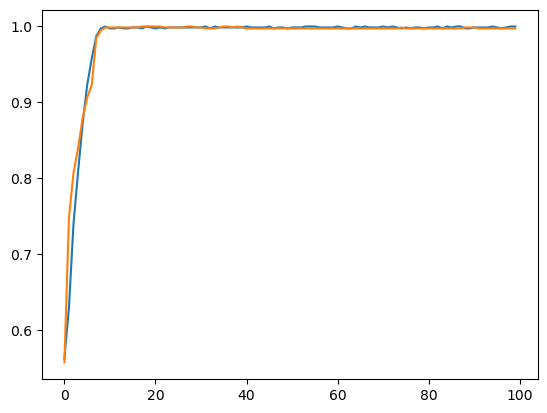

In [295]:
v_net = CNN_LSTM2()
v_criterion = nn.CrossEntropyLoss() # add to device here
v_optimizer = optim.Adam(v_net.parameters(), lr=0.001, weight_decay=1e-7)
train_net(v_net, v_optimizer, v_criterion, train_loader_v, val_loader_v, 100)

In [296]:
eval_net(v_net, test_loader_v)

Test acc: 0.9972222447


  2%|▏         | 1/50 [00:00<00:18,  2.59it/s]

Train acc: 0.584, Val acc: 0.550


  4%|▍         | 2/50 [00:00<00:17,  2.71it/s]

Train acc: 0.608, Val acc: 0.590


  6%|▌         | 3/50 [00:01<00:17,  2.76it/s]

Train acc: 0.630, Val acc: 0.621


  8%|▊         | 4/50 [00:01<00:16,  2.74it/s]

Train acc: 0.666, Val acc: 0.643


 10%|█         | 5/50 [00:01<00:16,  2.73it/s]

Train acc: 0.702, Val acc: 0.707


 12%|█▏        | 6/50 [00:02<00:16,  2.66it/s]

Train acc: 0.743, Val acc: 0.766


 14%|█▍        | 7/50 [00:02<00:16,  2.67it/s]

Train acc: 0.785, Val acc: 0.810


 16%|█▌        | 8/50 [00:02<00:15,  2.69it/s]

Train acc: 0.817, Val acc: 0.846


 18%|█▊        | 9/50 [00:03<00:15,  2.72it/s]

Train acc: 0.835, Val acc: 0.859


 20%|██        | 10/50 [00:03<00:14,  2.71it/s]

Train acc: 0.844, Val acc: 0.865


 22%|██▏       | 11/50 [00:04<00:14,  2.77it/s]

Train acc: 0.853, Val acc: 0.878


 24%|██▍       | 12/50 [00:04<00:13,  2.84it/s]

Train acc: 0.871, Val acc: 0.884


 26%|██▌       | 13/50 [00:04<00:13,  2.84it/s]

Train acc: 0.870, Val acc: 0.891


 28%|██▊       | 14/50 [00:05<00:12,  2.88it/s]

Train acc: 0.883, Val acc: 0.907


 30%|███       | 15/50 [00:05<00:12,  2.88it/s]

Train acc: 0.884, Val acc: 0.900


 32%|███▏      | 16/50 [00:05<00:11,  2.92it/s]

Train acc: 0.889, Val acc: 0.914


 34%|███▍      | 17/50 [00:06<00:11,  2.90it/s]

Train acc: 0.892, Val acc: 0.913


 36%|███▌      | 18/50 [00:06<00:11,  2.89it/s]

Train acc: 0.900, Val acc: 0.914


 38%|███▊      | 19/50 [00:06<00:11,  2.81it/s]

Train acc: 0.896, Val acc: 0.914


 40%|████      | 20/50 [00:07<00:10,  2.85it/s]

Train acc: 0.898, Val acc: 0.913


 42%|████▏     | 21/50 [00:07<00:10,  2.86it/s]

Train acc: 0.893, Val acc: 0.914


 44%|████▍     | 22/50 [00:07<00:09,  2.87it/s]

Train acc: 0.905, Val acc: 0.915


 46%|████▌     | 23/50 [00:08<00:09,  2.88it/s]

Train acc: 0.905, Val acc: 0.919


 48%|████▊     | 24/50 [00:08<00:09,  2.87it/s]

Train acc: 0.909, Val acc: 0.919


 50%|█████     | 25/50 [00:08<00:08,  2.88it/s]

Train acc: 0.913, Val acc: 0.916


 52%|█████▏    | 26/50 [00:09<00:08,  2.86it/s]

Train acc: 0.913, Val acc: 0.918


 54%|█████▍    | 27/50 [00:09<00:08,  2.85it/s]

Train acc: 0.911, Val acc: 0.910


 56%|█████▌    | 28/50 [00:09<00:07,  2.86it/s]

Train acc: 0.905, Val acc: 0.914


 58%|█████▊    | 29/50 [00:10<00:07,  2.78it/s]

Train acc: 0.916, Val acc: 0.915


 60%|██████    | 30/50 [00:10<00:07,  2.81it/s]

Train acc: 0.905, Val acc: 0.910


 62%|██████▏   | 31/50 [00:11<00:06,  2.80it/s]

Train acc: 0.922, Val acc: 0.911


 64%|██████▍   | 32/50 [00:11<00:06,  2.83it/s]

Train acc: 0.924, Val acc: 0.911


 66%|██████▌   | 33/50 [00:11<00:05,  2.85it/s]

Train acc: 0.931, Val acc: 0.911


 68%|██████▊   | 34/50 [00:12<00:05,  2.85it/s]

Train acc: 0.915, Val acc: 0.909


 70%|███████   | 35/50 [00:12<00:05,  2.85it/s]

Train acc: 0.923, Val acc: 0.916


 72%|███████▏  | 36/50 [00:12<00:04,  2.82it/s]

Train acc: 0.932, Val acc: 0.919


 74%|███████▍  | 37/50 [00:13<00:04,  2.80it/s]

Train acc: 0.922, Val acc: 0.906


 76%|███████▌  | 38/50 [00:13<00:04,  2.72it/s]

Train acc: 0.919, Val acc: 0.918


 78%|███████▊  | 39/50 [00:13<00:03,  2.76it/s]

Train acc: 0.931, Val acc: 0.905


 80%|████████  | 40/50 [00:14<00:03,  2.77it/s]

Train acc: 0.932, Val acc: 0.909


 82%|████████▏ | 41/50 [00:14<00:03,  2.79it/s]

Train acc: 0.931, Val acc: 0.913


 84%|████████▍ | 42/50 [00:14<00:02,  2.78it/s]

Train acc: 0.937, Val acc: 0.874


 86%|████████▌ | 43/50 [00:15<00:02,  2.81it/s]

Train acc: 0.923, Val acc: 0.907


 88%|████████▊ | 44/50 [00:15<00:02,  2.83it/s]

Train acc: 0.936, Val acc: 0.910


 90%|█████████ | 45/50 [00:16<00:01,  2.85it/s]

Train acc: 0.931, Val acc: 0.915


 92%|█████████▏| 46/50 [00:16<00:01,  2.82it/s]

Train acc: 0.924, Val acc: 0.896


 94%|█████████▍| 47/50 [00:16<00:01,  2.71it/s]

Train acc: 0.919, Val acc: 0.911


 96%|█████████▌| 48/50 [00:17<00:00,  2.73it/s]

Train acc: 0.927, Val acc: 0.866


 98%|█████████▊| 49/50 [00:17<00:00,  2.73it/s]

Train acc: 0.927, Val acc: 0.900


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]

Train acc: 0.925, Val acc: 0.911


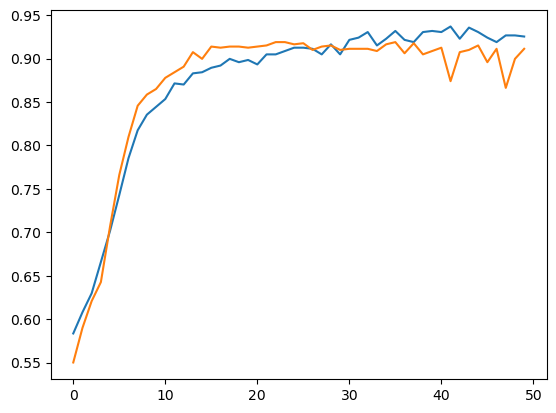

In [297]:
a_net = CNN_LSTM2()
a_criterion = nn.CrossEntropyLoss() # add to device here
a_optimizer = optim.Adam(a_net.parameters(), lr=0.001, weight_decay=1e-7)
train_net(a_net, a_optimizer, a_criterion, train_loader_a, val_loader_a, 50)

In [298]:
eval_net(a_net, test_loader_a)

Test acc: 0.8999999762


  1%|          | 1/100 [00:00<00:33,  2.99it/s]

Train acc: 0.590, Val acc: 0.697


  2%|▏         | 2/100 [00:00<00:32,  2.99it/s]

Train acc: 0.694, Val acc: 0.757


  3%|▎         | 3/100 [00:01<00:32,  2.98it/s]

Train acc: 0.801, Val acc: 0.844


  4%|▍         | 4/100 [00:01<00:32,  2.99it/s]

Train acc: 0.856, Val acc: 0.847


  5%|▌         | 5/100 [00:01<00:32,  2.94it/s]

Train acc: 0.873, Val acc: 0.852


  6%|▌         | 6/100 [00:02<00:32,  2.85it/s]

Train acc: 0.884, Val acc: 0.873


  7%|▋         | 7/100 [00:02<00:32,  2.87it/s]

Train acc: 0.897, Val acc: 0.883


  8%|▊         | 8/100 [00:02<00:31,  2.92it/s]

Train acc: 0.904, Val acc: 0.892


  9%|▉         | 9/100 [00:03<00:30,  2.95it/s]

Train acc: 0.902, Val acc: 0.896


 10%|█         | 10/100 [00:03<00:30,  2.95it/s]

Train acc: 0.905, Val acc: 0.901


 11%|█         | 11/100 [00:03<00:30,  2.95it/s]

Train acc: 0.904, Val acc: 0.904


 12%|█▏        | 12/100 [00:04<00:30,  2.93it/s]

Train acc: 0.905, Val acc: 0.905


 13%|█▎        | 13/100 [00:04<00:29,  2.94it/s]

Train acc: 0.906, Val acc: 0.906


 14%|█▍        | 14/100 [00:04<00:29,  2.94it/s]

Train acc: 0.914, Val acc: 0.906


 15%|█▌        | 15/100 [00:05<00:29,  2.84it/s]

Train acc: 0.907, Val acc: 0.906


 16%|█▌        | 16/100 [00:05<00:29,  2.89it/s]

Train acc: 0.907, Val acc: 0.906


 17%|█▋        | 17/100 [00:05<00:28,  2.89it/s]

Train acc: 0.913, Val acc: 0.907


 18%|█▊        | 18/100 [00:06<00:28,  2.89it/s]

Train acc: 0.918, Val acc: 0.907


 19%|█▉        | 19/100 [00:06<00:28,  2.88it/s]

Train acc: 0.923, Val acc: 0.909


 20%|██        | 20/100 [00:06<00:27,  2.88it/s]

Train acc: 0.920, Val acc: 0.907


 21%|██        | 21/100 [00:07<00:27,  2.91it/s]

Train acc: 0.923, Val acc: 0.906


 22%|██▏       | 22/100 [00:07<00:26,  2.92it/s]

Train acc: 0.945, Val acc: 0.910


 23%|██▎       | 23/100 [00:07<00:26,  2.92it/s]

Train acc: 0.932, Val acc: 0.909


 24%|██▍       | 24/100 [00:08<00:26,  2.90it/s]

Train acc: 0.937, Val acc: 0.909


 25%|██▌       | 25/100 [00:08<00:26,  2.79it/s]

Train acc: 0.937, Val acc: 0.907


 26%|██▌       | 26/100 [00:08<00:26,  2.80it/s]

Train acc: 0.947, Val acc: 0.909


 27%|██▋       | 27/100 [00:09<00:26,  2.79it/s]

Train acc: 0.932, Val acc: 0.909


 28%|██▊       | 28/100 [00:09<00:25,  2.80it/s]

Train acc: 0.952, Val acc: 0.909


 29%|██▉       | 29/100 [00:10<00:25,  2.77it/s]

Train acc: 0.938, Val acc: 0.907


 30%|███       | 30/100 [00:10<00:24,  2.80it/s]

Train acc: 0.949, Val acc: 0.909


 31%|███       | 31/100 [00:10<00:24,  2.83it/s]

Train acc: 0.942, Val acc: 0.909


 32%|███▏      | 32/100 [00:11<00:23,  2.84it/s]

Train acc: 0.949, Val acc: 0.907


 33%|███▎      | 33/100 [00:11<00:23,  2.82it/s]

Train acc: 0.959, Val acc: 0.910


 34%|███▍      | 34/100 [00:11<00:24,  2.72it/s]

Train acc: 0.949, Val acc: 0.910


 35%|███▌      | 35/100 [00:12<00:23,  2.73it/s]

Train acc: 0.955, Val acc: 0.910


 36%|███▌      | 36/100 [00:12<00:23,  2.72it/s]

Train acc: 0.956, Val acc: 0.910


 37%|███▋      | 37/100 [00:12<00:23,  2.73it/s]

Train acc: 0.951, Val acc: 0.909


 38%|███▊      | 38/100 [00:13<00:22,  2.75it/s]

Train acc: 0.963, Val acc: 0.910


 39%|███▉      | 39/100 [00:13<00:22,  2.73it/s]

Train acc: 0.964, Val acc: 0.910


 40%|████      | 40/100 [00:14<00:22,  2.71it/s]

Train acc: 0.967, Val acc: 0.909


 41%|████      | 41/100 [00:14<00:21,  2.71it/s]

Train acc: 0.963, Val acc: 0.909


 42%|████▏     | 42/100 [00:14<00:21,  2.74it/s]

Train acc: 0.964, Val acc: 0.907


 43%|████▎     | 43/100 [00:15<00:20,  2.74it/s]

Train acc: 0.964, Val acc: 0.909


 44%|████▍     | 44/100 [00:15<00:21,  2.67it/s]

Train acc: 0.964, Val acc: 0.909


 45%|████▌     | 45/100 [00:15<00:20,  2.71it/s]

Train acc: 0.965, Val acc: 0.910


 46%|████▌     | 46/100 [00:16<00:19,  2.75it/s]

Train acc: 0.961, Val acc: 0.910


 47%|████▋     | 47/100 [00:16<00:19,  2.77it/s]

Train acc: 0.963, Val acc: 0.910


 48%|████▊     | 48/100 [00:16<00:19,  2.73it/s]

Train acc: 0.963, Val acc: 0.910


 49%|████▉     | 49/100 [00:17<00:18,  2.74it/s]

Train acc: 0.967, Val acc: 0.911


 50%|█████     | 50/100 [00:17<00:18,  2.75it/s]

Train acc: 0.968, Val acc: 0.911


 51%|█████     | 51/100 [00:18<00:17,  2.73it/s]

Train acc: 0.970, Val acc: 0.911


 52%|█████▏    | 52/100 [00:18<00:17,  2.73it/s]

Train acc: 0.968, Val acc: 0.911


 53%|█████▎    | 53/100 [00:18<00:17,  2.64it/s]

Train acc: 0.972, Val acc: 0.911


 54%|█████▍    | 54/100 [00:19<00:17,  2.65it/s]

Train acc: 0.973, Val acc: 0.913


 55%|█████▌    | 55/100 [00:19<00:16,  2.69it/s]

Train acc: 0.968, Val acc: 0.913


 56%|█████▌    | 56/100 [00:19<00:16,  2.67it/s]

Train acc: 0.973, Val acc: 0.910


 57%|█████▋    | 57/100 [00:20<00:16,  2.67it/s]

Train acc: 0.972, Val acc: 0.910


 58%|█████▊    | 58/100 [00:20<00:15,  2.69it/s]

Train acc: 0.969, Val acc: 0.910


 59%|█████▉    | 59/100 [00:21<00:15,  2.68it/s]

Train acc: 0.972, Val acc: 0.911


 60%|██████    | 60/100 [00:21<00:14,  2.68it/s]

Train acc: 0.972, Val acc: 0.911


 61%|██████    | 61/100 [00:21<00:14,  2.69it/s]

Train acc: 0.968, Val acc: 0.911


 62%|██████▏   | 62/100 [00:22<00:14,  2.68it/s]

Train acc: 0.970, Val acc: 0.910


 63%|██████▎   | 63/100 [00:22<00:14,  2.59it/s]

Train acc: 0.972, Val acc: 0.910


 64%|██████▍   | 64/100 [00:23<00:13,  2.60it/s]

Train acc: 0.965, Val acc: 0.913


 65%|██████▌   | 65/100 [00:23<00:13,  2.62it/s]

Train acc: 0.974, Val acc: 0.911


 66%|██████▌   | 66/100 [00:23<00:12,  2.62it/s]

Train acc: 0.967, Val acc: 0.913


 67%|██████▋   | 67/100 [00:24<00:12,  2.65it/s]

Train acc: 0.970, Val acc: 0.913


 68%|██████▊   | 68/100 [00:24<00:12,  2.67it/s]

Train acc: 0.970, Val acc: 0.915


 69%|██████▉   | 69/100 [00:24<00:11,  2.65it/s]

Train acc: 0.973, Val acc: 0.918


 70%|███████   | 70/100 [00:25<00:11,  2.67it/s]

Train acc: 0.972, Val acc: 0.916


 71%|███████   | 71/100 [00:25<00:10,  2.68it/s]

Train acc: 0.972, Val acc: 0.916


 72%|███████▏  | 72/100 [00:26<00:10,  2.63it/s]

Train acc: 0.973, Val acc: 0.916


 73%|███████▎  | 73/100 [00:26<00:10,  2.67it/s]

Train acc: 0.972, Val acc: 0.916


 74%|███████▍  | 74/100 [00:26<00:09,  2.71it/s]

Train acc: 0.972, Val acc: 0.915


 75%|███████▌  | 75/100 [00:27<00:09,  2.72it/s]

Train acc: 0.972, Val acc: 0.918


 76%|███████▌  | 76/100 [00:27<00:08,  2.73it/s]

Train acc: 0.970, Val acc: 0.913


 77%|███████▋  | 77/100 [00:27<00:08,  2.75it/s]

Train acc: 0.973, Val acc: 0.915


 78%|███████▊  | 78/100 [00:28<00:08,  2.71it/s]

Train acc: 0.972, Val acc: 0.916


 79%|███████▉  | 79/100 [00:28<00:07,  2.70it/s]

Train acc: 0.972, Val acc: 0.916


 80%|████████  | 80/100 [00:28<00:07,  2.68it/s]

Train acc: 0.973, Val acc: 0.913


 81%|████████  | 81/100 [00:29<00:07,  2.58it/s]

Train acc: 0.972, Val acc: 0.916


 82%|████████▏ | 82/100 [00:29<00:06,  2.61it/s]

Train acc: 0.973, Val acc: 0.914


 83%|████████▎ | 83/100 [00:30<00:06,  2.65it/s]

Train acc: 0.974, Val acc: 0.915


 84%|████████▍ | 84/100 [00:30<00:05,  2.68it/s]

Train acc: 0.974, Val acc: 0.920


 85%|████████▌ | 85/100 [00:30<00:05,  2.69it/s]

Train acc: 0.970, Val acc: 0.916


 86%|████████▌ | 86/100 [00:31<00:05,  2.66it/s]

Train acc: 0.970, Val acc: 0.922


 87%|████████▋ | 87/100 [00:31<00:04,  2.66it/s]

Train acc: 0.973, Val acc: 0.920


 88%|████████▊ | 88/100 [00:31<00:04,  2.67it/s]

Train acc: 0.970, Val acc: 0.915


 89%|████████▉ | 89/100 [00:32<00:04,  2.65it/s]

Train acc: 0.972, Val acc: 0.918


 90%|█████████ | 90/100 [00:32<00:03,  2.57it/s]

Train acc: 0.970, Val acc: 0.914


 91%|█████████ | 91/100 [00:33<00:03,  2.59it/s]

Train acc: 0.973, Val acc: 0.918


 92%|█████████▏| 92/100 [00:33<00:03,  2.61it/s]

Train acc: 0.970, Val acc: 0.915


 93%|█████████▎| 93/100 [00:33<00:02,  2.67it/s]

Train acc: 0.972, Val acc: 0.916


 94%|█████████▍| 94/100 [00:34<00:02,  2.71it/s]

Train acc: 0.972, Val acc: 0.918


 95%|█████████▌| 95/100 [00:34<00:01,  2.72it/s]

Train acc: 0.972, Val acc: 0.915


 96%|█████████▌| 96/100 [00:34<00:01,  2.73it/s]

Train acc: 0.972, Val acc: 0.913


 97%|█████████▋| 97/100 [00:35<00:01,  2.73it/s]

Train acc: 0.969, Val acc: 0.919


 98%|█████████▊| 98/100 [00:35<00:00,  2.62it/s]

Train acc: 0.969, Val acc: 0.913


 99%|█████████▉| 99/100 [00:36<00:00,  2.63it/s]

Train acc: 0.972, Val acc: 0.924


100%|██████████| 100/100 [00:36<00:00,  2.74it/s]

Train acc: 0.969, Val acc: 0.915


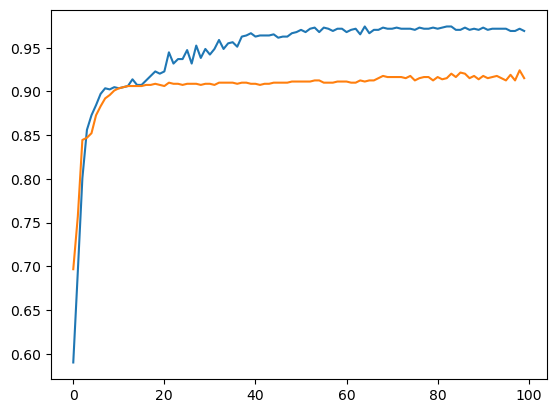

In [299]:
d_net = CNN_LSTM2()
d_criterion = nn.CrossEntropyLoss() # add to device here
d_optimizer = optim.Adam(d_net.parameters(), lr=0.001, weight_decay=1e-7)
train_net(d_net, d_optimizer, d_criterion, train_loader_d, val_loader_d, 100)

In [300]:
eval_net(d_net, test_loader_d)

Test acc: 0.9250000119


## Saving Nets

In [304]:
torch.save(v_net.state_dict(), cwd + '/valence_net')

In [305]:
torch.save(a_net.state_dict(), cwd + '/arousal_net')

In [306]:
torch.save(d_net.state_dict(), cwd + '/dominance_net')

In [308]:
tester = CNN_LSTM2()
tester.load_state_dict(torch.load(cwd + '/arousal_net'))

<All keys matched successfully>

In [309]:
eval_net(tester, test_loader_a)

Test acc: 0.8999999762


## Emotions (for later)

In [93]:
class CNN_LSTM2(nn.Module):
    def __init__(self):
        super(CNN_LSTM2, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=40, kernel_size=20, stride=4)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400,6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

In [107]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
emo_net = CNN_LSTM2()
print(emo_net.forward(Variable(input_tensor)))
e_criterion = nn.CrossEntropyLoss() # add to device here
e_optimizer = optim.Adam(emo_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[0.1613, 0.0997, 0.3030, 0.1494, 0.0997, 0.1868]],
       grad_fn=<SoftmaxBackward0>)


In [310]:
formal_emotions = emo_labels['Emo']
formal_emotions = formal_emotions.to_numpy()

In [311]:
formal_emotions = formal_emotions.reshape((formal_emotions.size, 1))

In [99]:
from sklearn.preprocessing import OneHotEncoder
cat = OneHotEncoder()
emotions_onehot = cat.fit_transform(formal_emotions).toarray()

In [105]:
y_train_e = emotion_labels[train_indices]
y_valid_e = emotion_labels[valid_indices]
y_test_e = emotion_labels[test_indices]

In [106]:
train_subset_e = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_e))
val_subset_e = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_e))
test_dataset_e = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_e))

train_loader_e = torch.utils.data.DataLoader(train_subset_v, shuffle=True, batch_size=bsz)
val_loader_e = torch.utils.data.DataLoader(val_subset_v, shuffle=False, batch_size=bsz)
test_loader_e = torch.utils.data.DataLoader(test_dataset_v, shuffle=False, batch_size=bsz)

  2%|▏         | 1/50 [00:01<01:33,  1.91s/it]

Train acc: 0.521, Val acc: 0.693


  4%|▍         | 2/50 [00:03<01:28,  1.84s/it]

Train acc: 0.754, Val acc: 0.823


  6%|▌         | 3/50 [00:05<01:22,  1.75s/it]

Train acc: 0.878, Val acc: 0.849


  8%|▊         | 4/50 [00:06<01:17,  1.69s/it]

Train acc: 0.946, Val acc: 0.903


 10%|█         | 5/50 [00:08<01:15,  1.68s/it]

Train acc: 0.984, Val acc: 0.981


 12%|█▏        | 6/50 [00:10<01:13,  1.66s/it]

Train acc: 0.999, Val acc: 0.973


 14%|█▍        | 7/50 [00:11<01:10,  1.64s/it]

Train acc: 0.999, Val acc: 0.994


 16%|█▌        | 8/50 [00:13<01:09,  1.66s/it]

Train acc: 1.000, Val acc: 0.997


 18%|█▊        | 9/50 [00:15<01:08,  1.67s/it]

Train acc: 1.000, Val acc: 0.996


 20%|██        | 10/50 [00:16<01:07,  1.68s/it]

Train acc: 1.000, Val acc: 0.981


 22%|██▏       | 11/50 [00:18<01:04,  1.66s/it]

Train acc: 1.000, Val acc: 0.997


 24%|██▍       | 12/50 [00:20<01:02,  1.65s/it]

Train acc: 1.000, Val acc: 1.000


 26%|██▌       | 13/50 [00:21<01:00,  1.62s/it]

Train acc: 1.000, Val acc: 0.994


 28%|██▊       | 14/50 [00:24<01:06,  1.84s/it]

Train acc: 1.000, Val acc: 1.000


 30%|███       | 15/50 [00:26<01:05,  1.88s/it]

Train acc: 1.000, Val acc: 1.000


 32%|███▏      | 16/50 [00:27<01:03,  1.87s/it]

Train acc: 1.000, Val acc: 0.997


 34%|███▍      | 17/50 [00:29<00:59,  1.80s/it]

Train acc: 1.000, Val acc: 1.000


 36%|███▌      | 18/50 [00:31<00:56,  1.76s/it]

Train acc: 1.000, Val acc: 1.000


 38%|███▊      | 19/50 [00:32<00:53,  1.74s/it]

Train acc: 1.000, Val acc: 0.997


 40%|████      | 20/50 [00:34<00:50,  1.69s/it]

Train acc: 1.000, Val acc: 0.997


 42%|████▏     | 21/50 [00:35<00:47,  1.64s/it]

Train acc: 1.000, Val acc: 0.993


 44%|████▍     | 22/50 [00:37<00:45,  1.63s/it]

Train acc: 1.000, Val acc: 0.981


 46%|████▌     | 23/50 [00:39<00:44,  1.64s/it]

Train acc: 1.000, Val acc: 0.988


 48%|████▊     | 24/50 [00:40<00:41,  1.58s/it]

Train acc: 1.000, Val acc: 0.999


 50%|█████     | 25/50 [00:42<00:39,  1.58s/it]

Train acc: 1.000, Val acc: 0.999


 52%|█████▏    | 26/50 [00:43<00:38,  1.59s/it]

Train acc: 1.000, Val acc: 0.997


 54%|█████▍    | 27/50 [00:45<00:37,  1.62s/it]

Train acc: 1.000, Val acc: 1.000


 56%|█████▌    | 28/50 [00:47<00:35,  1.61s/it]

Train acc: 1.000, Val acc: 0.997


 58%|█████▊    | 29/50 [00:48<00:34,  1.66s/it]

Train acc: 1.000, Val acc: 1.000


 60%|██████    | 30/50 [00:50<00:33,  1.68s/it]

Train acc: 1.000, Val acc: 0.997


 62%|██████▏   | 31/50 [00:53<00:38,  2.03s/it]

Train acc: 1.000, Val acc: 1.000


 64%|██████▍   | 32/50 [00:56<00:40,  2.23s/it]

Train acc: 1.000, Val acc: 0.997


 66%|██████▌   | 33/50 [00:57<00:35,  2.08s/it]

Train acc: 1.000, Val acc: 1.000


 68%|██████▊   | 34/50 [00:59<00:31,  1.95s/it]

Train acc: 1.000, Val acc: 1.000


 70%|███████   | 35/50 [01:01<00:27,  1.86s/it]

Train acc: 1.000, Val acc: 0.997


 72%|███████▏  | 36/50 [01:02<00:25,  1.82s/it]

Train acc: 1.000, Val acc: 1.000


 74%|███████▍  | 37/50 [01:04<00:22,  1.74s/it]

Train acc: 1.000, Val acc: 0.997


 76%|███████▌  | 38/50 [01:05<00:20,  1.68s/it]

Train acc: 1.000, Val acc: 0.988


 78%|███████▊  | 39/50 [01:07<00:18,  1.67s/it]

Train acc: 1.000, Val acc: 0.963


 80%|████████  | 40/50 [01:09<00:16,  1.66s/it]

Train acc: 0.991, Val acc: 0.917


 82%|████████▏ | 41/50 [01:10<00:14,  1.62s/it]

Train acc: 1.000, Val acc: 1.000


 84%|████████▍ | 42/50 [01:12<00:12,  1.62s/it]

Train acc: 0.996, Val acc: 1.000


 86%|████████▌ | 43/50 [01:14<00:11,  1.69s/it]

Train acc: 1.000, Val acc: 0.975


 88%|████████▊ | 44/50 [01:16<00:10,  1.70s/it]

Train acc: 0.999, Val acc: 0.991


 90%|█████████ | 45/50 [01:17<00:08,  1.68s/it]

Train acc: 0.996, Val acc: 0.960


 92%|█████████▏| 46/50 [01:19<00:06,  1.61s/it]

Train acc: 0.988, Val acc: 0.963


 94%|█████████▍| 47/50 [01:20<00:05,  1.69s/it]

Train acc: 0.999, Val acc: 1.000


 96%|█████████▌| 48/50 [01:22<00:03,  1.70s/it]

Train acc: 1.000, Val acc: 0.987


 98%|█████████▊| 49/50 [01:24<00:01,  1.87s/it]

Train acc: 0.999, Val acc: 0.985


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]

Train acc: 0.997, Val acc: 1.000


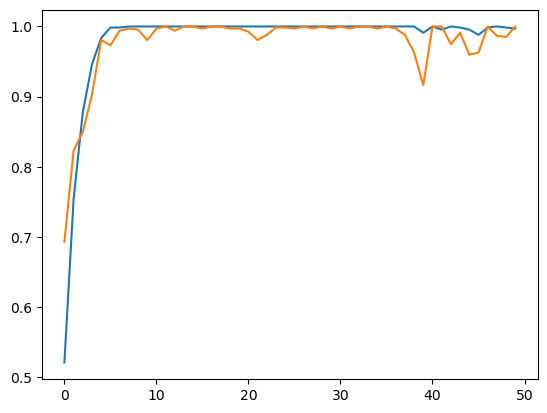

In [108]:
train_net(emo_net, e_optimizer, e_criterion, train_loader_e, val_loader_e, 50)

In [109]:
eval_net(emo_net, test_loader_e)

Test acc: 1.0000000000
